In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
index_chapitres = joblib.load("/home/crazyjeannot/Documents/doctorat/data/data_chapitres/lemmatizers/spring_2024/INDEX_CHAPITRES.pkl")
feats_chapitres = joblib.load("/home/crazyjeannot/Documents/doctorat/data/data_chapitres/lemmatizers/spring_2024/FEATS_CHAPITRES.pkl")

In [3]:
def count_verb_tenses(novel_feats):
    tense_counts = {'Présent': 0, 'Imparfait': 0, 'Passé simple': 0, 'Passé composé': 0, 'Futur': 0, 'Plus que parfait': 0}
    for sentences_feats in novel_feats:
        feats = sentences_feats.split()
        for i in range(len(feats)):
            current_feats = feats[i].split('|')
            if (i+1) < len(feats):
                next_feats = feats[i+1].split('|')
            else:
                next_feats=['']
            # get présent and passé composé
            if 'Tense=Pres' in current_feats and 'VerbForm=Fin' in current_feats:
                # Check if the next verb form is Part (indicating Passé composé)
                if 'VerbForm=Part' in next_feats and 'Tense=Past' in next_feats:
                    tense_counts['Passé composé'] += 1
                else:
                    tense_counts['Présent'] += 1

            if 'Tense=Imp' in current_feats and 'VerbForm=Fin' in current_feats:
                # Check if the next verb form is Part (indicating Passé composé)
                if 'VerbForm=Part' in next_feats and 'Tense=Past' in next_feats:
                    tense_counts['Plus que parfait'] += 1
                else:
                    tense_counts['Imparfait'] += 1
                
            if 'Tense=Fut' in current_feats and 'VerbForm=Fin' in current_feats:
                    tense_counts['Futur'] += 1

            if 'Tense=Past' in current_feats and 'VerbForm=Fin' in current_feats:
                    tense_counts['Passé simple'] += 1
    return tense_counts

In [4]:
def moulinette(list_book_feats):
    list_tense_counts = []
    for list_feats in tqdm(list_book_feats):
        tense_counts = count_verb_tenses(list_feats)
        list_tense_counts.append(tense_counts)
    return list_tense_counts

In [50]:
compte_temps = moulinette(feats_chapitres)

  0%|          | 0/2960 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(compte_temps)

In [52]:
df['col_name'] = index_chapitres

In [53]:
df = df[['col_name', 'Présent', 'Imparfait', 'Passé simple', 'Passé composé', 'Futur', 'Plus que parfait']]

In [54]:
df['date'] = df['col_name'].str.split('_', n=1).str[0].astype(int)

In [55]:
df

,col_name,Présent,Imparfait,Passé simple,Passé composé,Futur,Plus que parfait,date
0,1954_San-Antonio_Messieurs-les-hommes,4770,165,11,481,80,20,1954
1,1957_Pagnol-Marcel_La-Gloire-de-mon-pere,3049,1348,848,359,103,206,1957
2,1957_Simenon-Georges_Maigret-voyage,2393,1227,440,654,61,195,1957
3,1845_Balzac-Honore-de_L-Elixir-de-longue-vie,388,189,194,48,21,24,1845
4,1884_Halt-Robert_Marianne,2741,1357,1397,455,157,180,1884
...,...,...,...,...,...,...,...,...
2955,1954_Delly_Aelys-aux-cheveux-d'or,3294,1717,1159,455,292,293,1954
2956,1926_Bernanos-Georges_Sous-le-soleil-de-Satan,6431,1253,1321,938,240,169,1926
2957,1926_Crevel-René_La-mort-difficile,3854,488,104,555,169,104,1926
2958,1877_Gayet-de-Cesena-Amedee_Le-Chapelet-d-amour,2633,1323,853,542,115,378,1877


In [11]:
df_melted = pd.melt(df, id_vars=['col_name', 'date'], var_name='Tense', value_name='Frequency')

In [16]:
df_normalized = df.groupby(df['date'], group_keys=False).apply(lambda x: x.iloc[:, 1:-1].div(x.iloc[:, 1:-1].sum(axis=1), axis=0) * 100).reset_index()

/tmp/ipykernel_67829/1379283564.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = df.groupby(df['date'], group_keys=False).apply(lambda x: x.iloc[:, 1:-1].div(x.iloc[:, 1:-1].sum(axis=1), axis=0) * 100).reset_index()


In [17]:
df_normalized['date']=df['date']

In [18]:
df_test = df_normalized[['date', 'Imparfait', 'Passé simple', 'Présent', 'Passé composé', 'Futur', 'Plus que parfait']]

In [19]:
df_melted = pd.melt(df_test, id_vars=['date'], var_name='Tense', value_name='Normalized Frequency')

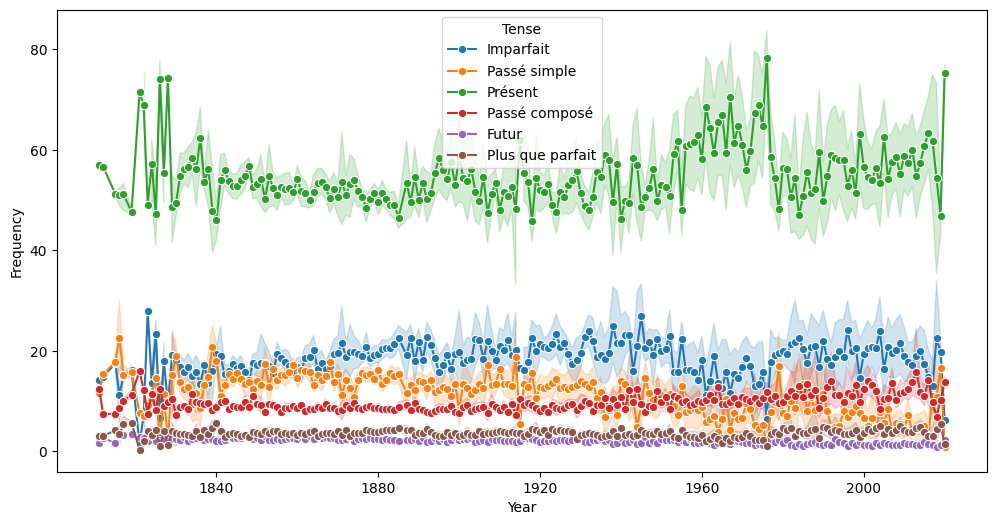

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='Tense', data=df_melted, marker='o')

# Set plot title and labels
#plt.title('Frequency of Verb Tenses Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.savefig('all_normalized.png', format='png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

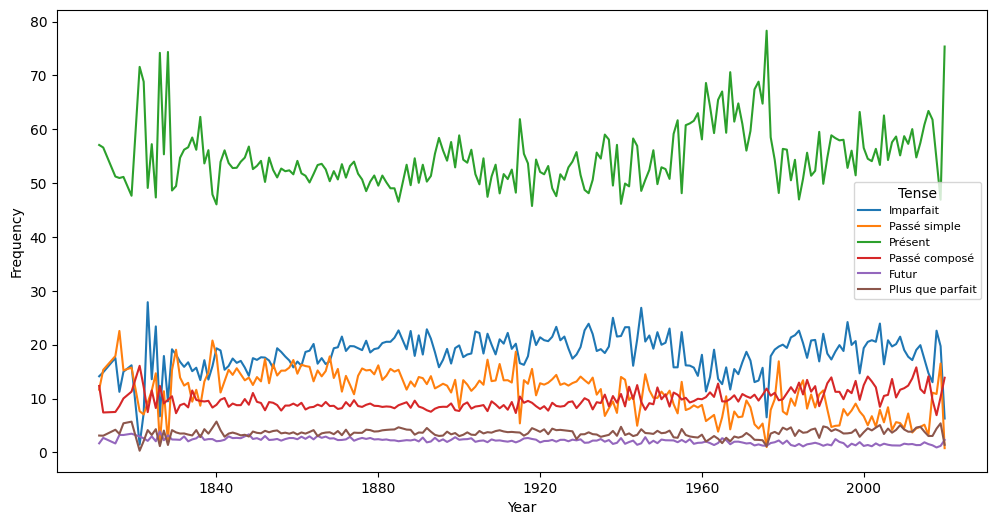

In [44]:
# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', errorbar=None, hue='Tense', data=df_melted)

# Adjust the legend to appear outside the plot
plt.legend(title='Tense', loc='best', prop={'size': 8})# upper left

# Set plot labels
plt.xlabel('Year')
plt.ylabel('Frequency')

# Save the plot
plt.savefig('all_normalized.png', format='png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [58]:
custom_palette = {
    'Passé composé': '#87CEEB',   # Light blue
    'Présent': '#4682B4',         # Steel blue
    'Futur': '#1E90FF',           # Dodger blue
    'Imparfait': '#FFA07A',       # Light salmon
    'Plus que parfait': '#CD5C5C',# Indian red
    'Passé simple': '#E57373'     # Intermediate orange/red
}

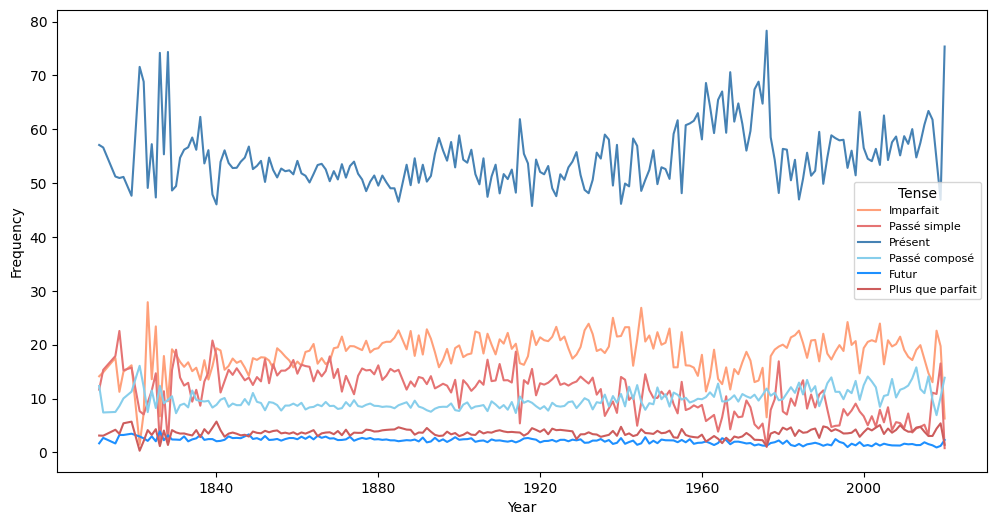

In [59]:
# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='Tense', data=df_melted, errorbar=None, palette=custom_palette)

# Adjust the legend to appear outside the plot
plt.legend(title='Tense', loc='best', prop={'size': 8})# upper left

# Set plot labels
plt.xlabel('Year')
plt.ylabel('Frequency')

# Save the plot
plt.savefig('all_normalized_red_blue.png', format='png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [51]:
df_test = df_normalized[['date', 'Imparfait', 'Passé simple']]#, 'Passé composé', 'Futur', 'Plus que parfait']]

In [52]:
df_melted = pd.melt(df_test, id_vars=['date'], var_name='Tense', value_name='Normalized Frequency')

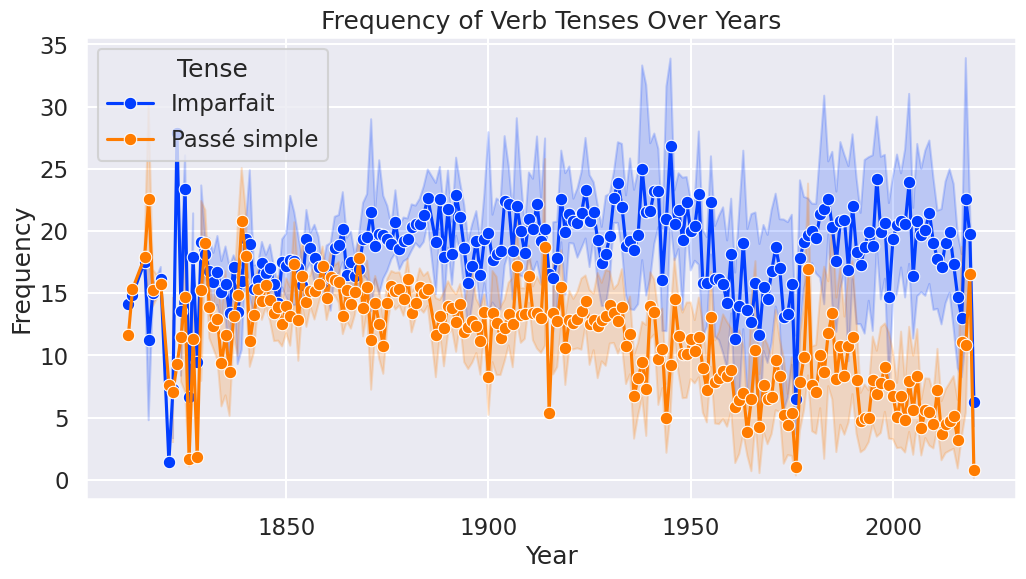

In [53]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='Tense', data=df_melted, marker='o')

# Set plot title and labels
plt.title('Frequency of Verb Tenses Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

#plt.savefig('imparfait_passe-simple_normalized.png', format='png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [23]:
df_test = df_normalized[['date', 'Imparfait', 'Passé simple', 'Passé composé']]

In [24]:
df_melted = pd.melt(df_test, id_vars=['date'], var_name='Tense', value_name='Normalized Frequency')

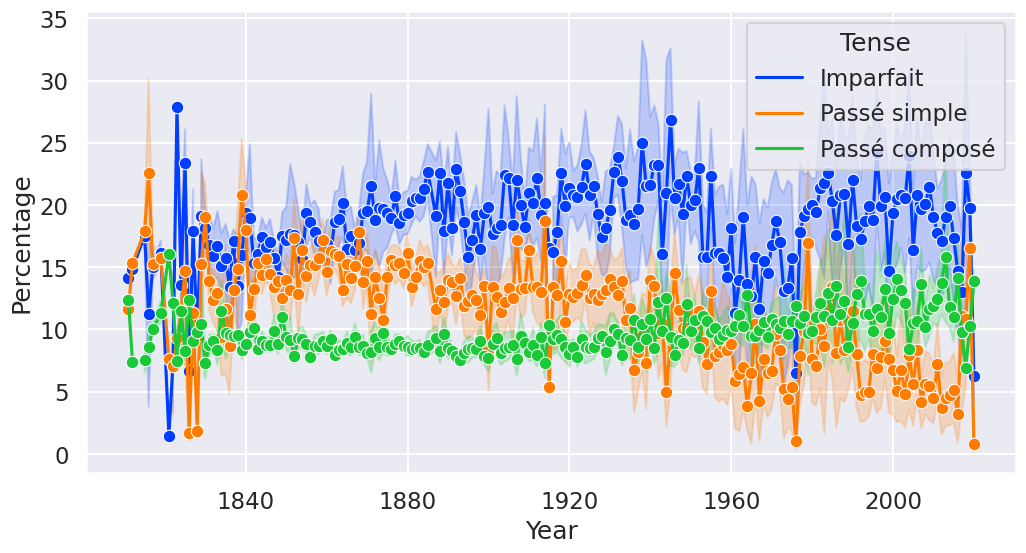

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='Tense', data=df_melted, marker='o')

# Set plot title and labels
#plt.title('Percentage of Verb Tenses Over Years')
plt.xlabel('Year')
plt.ylabel('Percentage')

plt.savefig('imparfait_passe-simple_compose_normalized.png', format='png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# Get Canonical Info

In [45]:
df_corpus_canon = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/df_canon_spec_last.csv')
df_corpus_canon.set_index(['doc_name'], inplace=True)

In [63]:
def get_df_with_canon(df, df_corpus):
    df_res = df.copy()
    list_canon = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            list_canon.append(df_corpus.loc[elem].canon_auteur)#canon_auteur / canon_roman
        else:
            list_canon.append('canon')# 6 pb - Proust la recherche et hugo l'homme qui rit
            print(elem)
    df_res['canon'] = list_canon

    return df_res

In [210]:
df_test = df[['date', 'Plus que parfait', 'Passé simple', 'Imparfait', "Présent", 'Passé composé', 'Futur']]#, 'Passé composé', 'Futur', 'Plus que parfait']]

In [211]:
df_normalized = df_test.groupby(df_test['date'].dt.year, group_keys=False).apply(lambda x: x.iloc[:, 1:-1].div(x.iloc[:, 1:-1].sum(axis=1), axis=0) * 100)

In [212]:
df_normalized.index = df.col_name

In [213]:
df_normalized['date']=list(df_test['date'].dt.year)

In [60]:
df.set_index('col_name', inplace=True)

In [62]:
df_MAIN_canon = get_df_with_canon(df, df_corpus_canon)

1927_Proust-Marcel_Le-Temps-retrouve-A-la-recherche-du-temps-perdu
1918_Proust-Marcel_A-l-ombre-des-jeunes-filles-en-fleurs-A-la-recherche-du-temps-perdu
1869_Hugo-Victor_L'homme-qui-rit
1921_Proust-Marcel_Sodome-et-Gomorrhe-A-la-recherche-du-temps-perdu
1923_Proust-Marcel_La-Prisonniere-A-la-recherche-du-temps-perdu
1913_Proust-Marcel_Du-cote-de-chez-Swann-A-la-recherche-du-temps-perdu


In [64]:
df_MAIN_canon.canon.value_counts()

canon
non_canon    1787
canon        1173
Name: count, dtype: int64

In [65]:
df_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/corpus.csv')
df_corpus.set_index(['doc_name'], inplace=True)

In [66]:
def get_df_with_subgenre(df, df_corpus):
    df_res = df.copy()
    list_subgenre = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            list_subgenre.append(df_corpus.loc[elem].genre)
        else:
            list_subgenre.append('')
    df_res['subgenre'] = list_subgenre

    return df_res

In [67]:
df_MAIN_genred = get_df_with_subgenre(df_MAIN_canon, df_corpus)

In [69]:
# Use a lambda function for conditional replacement
df_MAIN_genred['canon'] = df_MAIN_genred['canon'].apply(lambda x: 1 if x == 'canon' else 0)

In [72]:
df_MAIN_genred.subgenre.value_counts()

subgenre
roman d'aventures               364
policier                        307
roman historique                207
nouvelles                       186
cycles et séries                169
littérature jeunesse            146
mémoires et autobiographie      136
roman sentimental               133
érotisme                        107
fantastique                      66
récit de voyage                  34
épistolaire                      33
science-fiction                  31
non-fiction                      25
fragments                        16
journal intime                    8
                                  6
biographie                        5
roman historique                  3
 mémoires et autobiographie       2
 nouvelles                        2
ciné-roman                        1
 littérature jeunesse             1
littérature jeunesse              1
littérature à contraintes         1
 roman sentimental                1
Name: count, dtype: int64

In [73]:
subgenre_mapping = {
    1: "adventure novel",
    2: "detective novel",
    3: "historical novel",
    4: "short stories",
    5: "cycles and series",
    6: "children's literature",
    7: "memoirs and autobiography",
    8: "romantic novel",
    9: "eroticism",
    10: "fantasy",
    11: "travel narrative",
    12: "epistolary novel",
    13: "science fiction"
}

In [74]:
# Mapping subgenre names to numbersdf['subgenre'] = df['subgenre'].replace(subgenre_to_number)
subgenre_to_number = {
    'roman d\'aventures': 1,
    'policier': 2,
    'roman historique': 3,
    'nouvelles': 4,
    'cycles et séries': 5,
    'littérature jeunesse': 6,
    'mémoires et autobiographie': 7,
    'roman sentimental': 8,
    'érotisme': 9,
    'fantastique': 10,
    'récit de voyage': 11,
    'épistolaire': 12,
    'science-fiction': 13
}

# Replace subgenre with numeric values
df_MAIN_genred['subgenre'] = df_MAIN_genred['subgenre'].replace(subgenre_to_number)

In [76]:
df_MAIN_genred.to_csv("df_metadated_floflo.csv", header=True, index=True)

In [216]:
df_melted = pd.melt(df_MAIN_canon, id_vars=['date','canon'], var_name='Tense', value_name='Normalized Frequency')

In [217]:
df_melted.Tense.value_counts()

Plus que parfait    2960
Passé simple        2960
Imparfait           2960
Présent             2960
Passé composé       2960
Name: Tense, dtype: int64

In [218]:
df_melted_présent = df_melted[df_melted['Tense']=='Présent']

In [219]:
df_melted_imparfait = df_melted[df_melted['Tense']=='Imparfait']

In [220]:
df_melted_passé_simple = df_melted[df_melted['Tense']=='Passé simple']

In [221]:
df_melted_passé_composé = df_melted[df_melted['Tense']=='Passé composé']

In [222]:
df_melted_imparfait.canon.value_counts()

non_canon    1787
canon        1173
Name: canon, dtype: int64

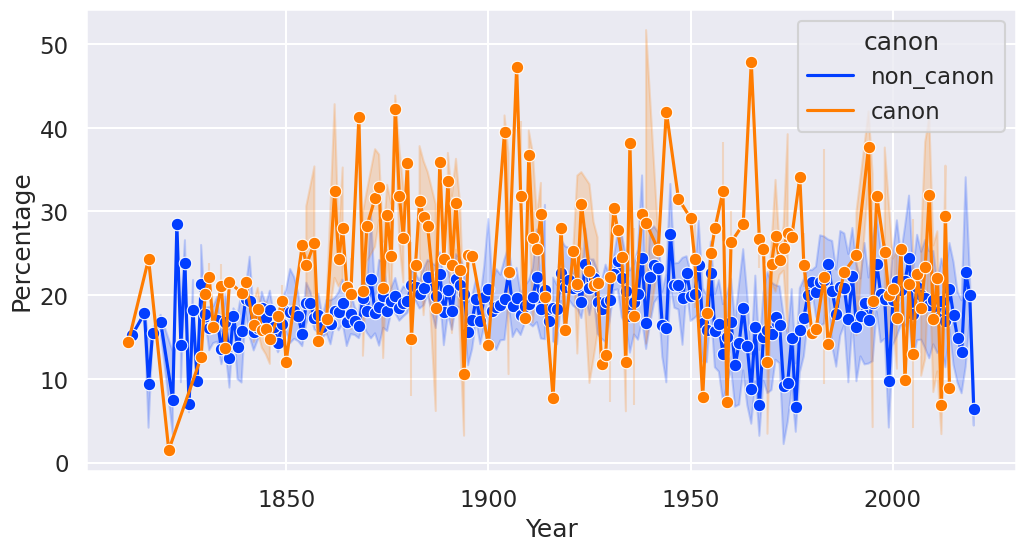

In [203]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='canon', data=df_melted_imparfait, marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')

plt.savefig('imparfait_canonized_roman.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

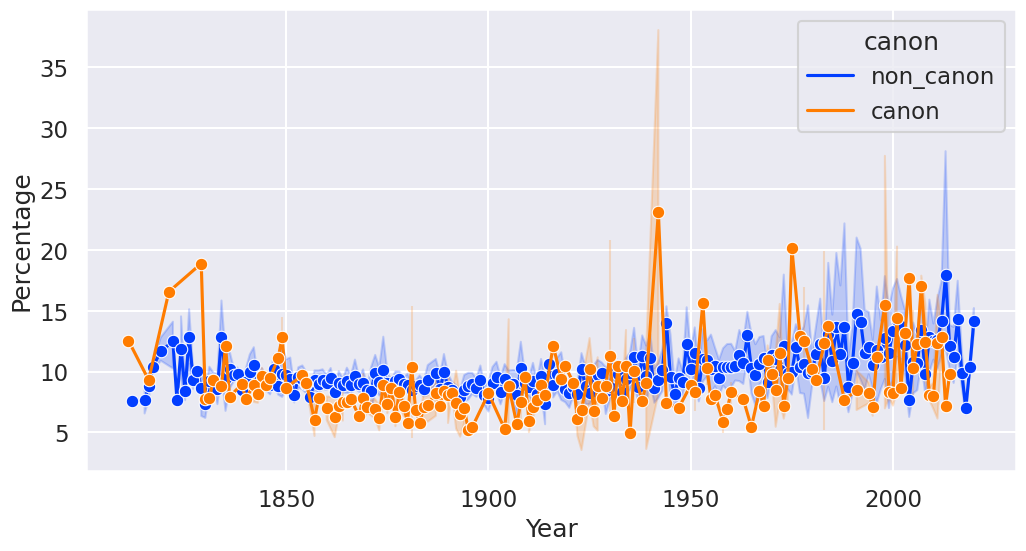

In [204]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='canon', data=df_melted_passé_composé, marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')

plt.savefig('passé_composé_canonized_roman.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

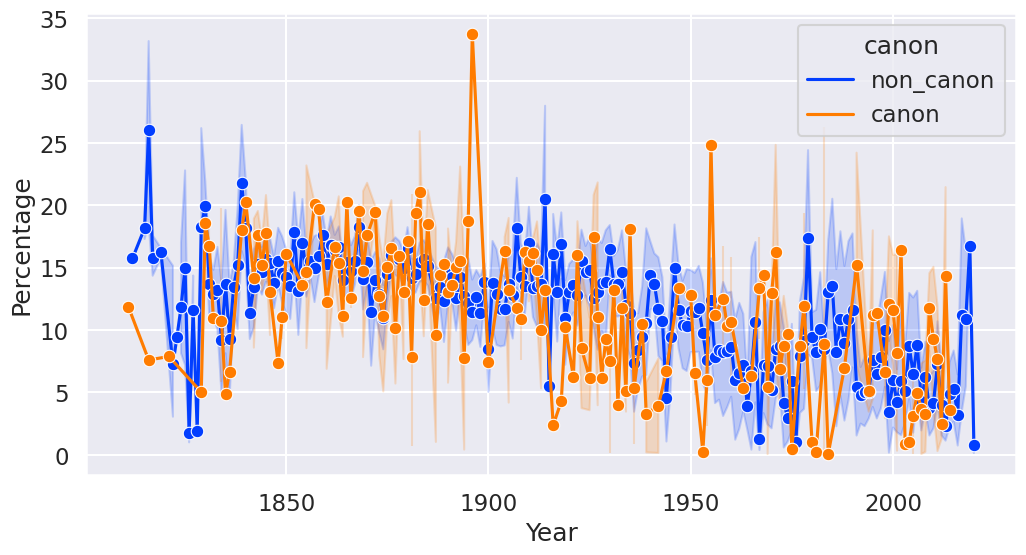

In [205]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='canon', data=df_melted_passé_simple, marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')

plt.savefig('passé_simple_canonized_roman.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

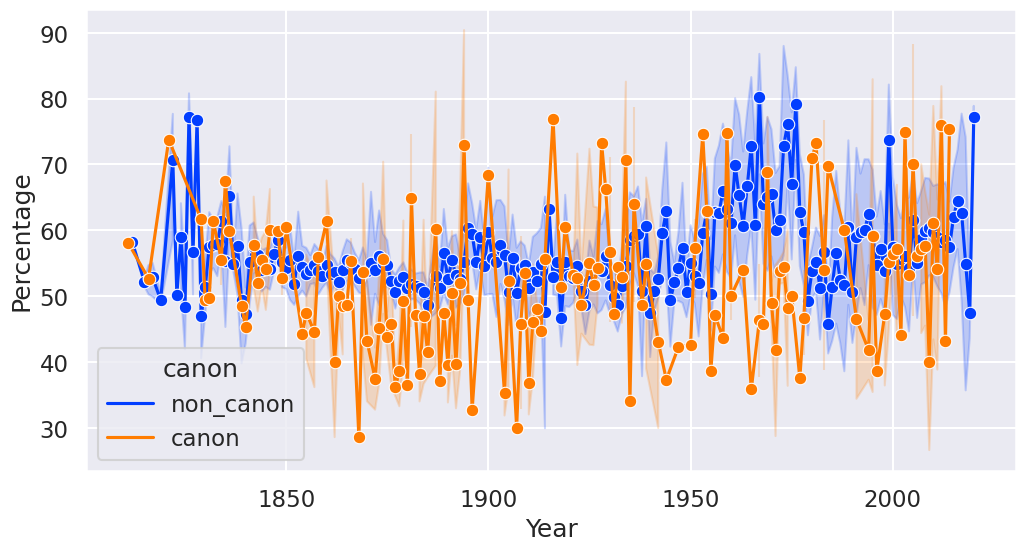

In [206]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Normalized Frequency', hue='canon', data=df_melted_présent, marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')

plt.savefig('présent_canonized_roman.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

In [227]:
test = df_MAIN_canon[(df_MAIN_canon["canon"]=="canon") & (df_MAIN_canon["date"]>=1950) & (df_MAIN_canon["date"]<=1970)]

In [229]:
list(test.index )

['1957_Pagnol-Marcel_La-Gloire-de-mon-pere',
 '1957_Simenon-Georges_Maigret-voyage',
 '1959_Queneau-Raymond_Zazie-Dans-Le-Metro',
 '1950_Hemon-Louis_Monsieur-Ripois-et-la-Nemesis',
 '1964_Simenon-Georges_Maigret-et-le-fantome',
 '1969_Simenon-Georges_Maigret-et-le-tueur',
 '1968_Dhotel-Andre_L-Enfant-qui-disait-n-importe-quoi',
 '1958_Aragon-Louis_La-semaine-sainte',
 '1963_Pagnol-Marcel_Manon-des-sources',
 '1958_Beauvoir-Simone-de_Memoires-d-une-jeune-fille-rangee',
 '1954_Beauvoir-Simone-de_Les-Mandarins_2',
 '1951_Simenon-Georges_Maigret-au-Picratt-s',
 '1953_Simenon-Georges_Maigret-se-trompe',
 '1965_Delbo-Charlotte_Auschwitz-et-apres_I-Aucun-de-nous-ne-reviendra',
 '1954_Simenon-Georges_Maigret-et-la-jeune-morte',
 '1967_Simon-Claude_Histoire',
 '1968_Modiano-Patrick_La-Place-de-l-etoile',
 '1951_Simenon-Georges_Maigret-et-la-grande-perche',
 '1953_Simenon-Georges_Maigret-et-l-homme-du-banc',
 '1963_Beauvoir-Simone-de_La-force-des-choses_1',
 '1963_Green-Julien_Partir-avant-le-jo

In [224]:
test = df_MAIN_canon[(df_MAIN_canon["canon"]=="non_canon") & (df_MAIN_canon["date"]>=1950) & (df_MAIN_canon["date"]<=1970)]

In [226]:
list(test.index)

['1954_San-Antonio_Messieurs-les-hommes',
 '1953_San-Antonio_Des-dragees-sans-bapteme',
 '1960_Delly_Le-sceau-de-Satan',
 '1954_San-Antonio_Bas-les-pattes',
 '1953_San-Antonio_Des-clientes-pour-la-morgue',
 '1958_San-Antonio_En-long-en-large-et-en-travers',
 '1961_San-Antonio_De-A-jusqu-a-Z',
 '1968_Barjavel-Rene_La-nuit-des-temps',
 '1954_San-Antonio_Rue-des-macchabees',
 '1953_Delly_Le-repaire-des-fauves',
 '1954_Simonin-Albert_Le-cave-se-rebiffe',
 '1960_San-Antonio_Berceuse-pour-Berurier',
 '1962_San-Antonio_Le-loup-habille-en-grand-mere',
 "1951_Delly_La-maison-des-belles-colonnes-L'accusatrice",
 '1961_San-Antonio_Y-a-bon-San-Antonio',
 '1962_San-Antonio_San-Antonio-chez-les-Gones',
 '1960_San-Antonio_Du-sirop-pour-les-guepes',
 '1951_Delly_Reinette',
 '1956_San-Antonio_Des-gueules-d-enterrement',
 '1967_San-Antonio_Beru-contre-San-Antonio',
 '1965_De-Villiers-Gerard_SAS-a-Istanbul',
 '1956_Delly_Annonciade',
 '1958_San-Antonio_Du-poulet-au-menu',
 '1956_San-Antonio_Les-doigts-da

In [3]:
index_chapitres_1 = joblib.load("INDEX_GALLICA_1000.pkl")
index_chapitres_2 = joblib.load("INDEX_GALLICA_2000.pkl")
index_chapitres_3 = joblib.load("INDEX_GALLICA_3000.pkl")
index_chapitres_4 = joblib.load("INDEX_GALLICA_4000.pkl")
index_chapitres_5 = joblib.load("INDEX_GALLICA_5000.pkl")
index_chapitres_6 = joblib.load("INDEX_GALLICA_6000.pkl")
index_chapitres_7 = joblib.load("INDEX_GALLICA_7000.pkl")
index_chapitres_8 = joblib.load("INDEX_GALLICA_8000.pkl")
index_chapitres_9 = joblib.load("INDEX_GALLICA_9000.pkl")
index_chapitres_10 = joblib.load("INDEX_GALLICA_10000.pkl")

In [4]:
index = index_chapitres_1+index_chapitres_2+index_chapitres_3+index_chapitres_4+index_chapitres_5+index_chapitres_6+index_chapitres_7+index_chapitres_8+index_chapitres_9+index_chapitres_10

In [5]:
len(index)

10000

In [6]:
len(set(index))

10000